# Discretization

---

In this notebook, you will deal with continuous state and action spaces by discretizing them. This will enable you to apply reinforcement learning algorithms that are only designed to work with discrete spaces.

### 1. Import the Necessary Packages

In [1]:
import sys
import gym
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

# Set plotting options
%matplotlib inline
plt.style.use('ggplot')
np.set_printoptions(precision=3, linewidth=120)

### 2. Specify the Environment, and Explore the State and Action Spaces

We'll use [OpenAI Gym](https://gym.openai.com/) environments to test and develop our algorithms. These simulate a variety of classic as well as contemporary reinforcement learning tasks.  Let's use an environment that has a continuous state space, but a discrete action space.  
https://github.com/openai/gym/wiki/MountainCar-v0

In [2]:
# Create an environment and set random seed
env = gym.make('MountainCar-v0')
env.seed(505);

Run the next code cell to watch a random agent.

In [7]:
state = env.reset()
score = 0
for t in range(200):
    action = env.action_space.sample()
    env.render()
    state, reward, done, _ = env.step(action)
    score += reward
    if done:
        break 
print('Final score:', score)
env.close()

Final score: -200.0


In this notebook, you will train an agent to perform much better!  For now, we can explore the state and action spaces, as well as sample them.  

The first figure is "position", the second is "velocity"

In [21]:
list(env.observation_space.sample())

[0.5124801, 0.036833793]

|Num|Observation|Lower bound|Upper bound|  
|---|---|---|---|  
|0|position|-1.2|0.6|  
|1|velocity|-0.07|0.07|

In [8]:
# Explore state (observation) space
print("State space:", env.observation_space)
print("- low:", env.observation_space.low)
print("- high:", env.observation_space.high)

State space: Box(2,)
- low: [-1.2  -0.07]
- high: [0.6  0.07]


In [9]:
# Generate some samples from the state space 
print("State space samples:")
print(np.array([env.observation_space.sample() for i in range(10)]))

State space samples:
[[-0.785  0.062]
 [-0.116 -0.068]
 [ 0.035  0.042]
 [-0.628 -0.033]
 [-0.812 -0.059]
 [ 0.523  0.07 ]
 [-0.644  0.06 ]
 [ 0.575  0.004]
 [ 0.115  0.042]
 [-0.763  0.05 ]]


**Actions**  
type: Discrete(3)

|Num|Action|  
|---|---|  
|0|push left|  
|1|no push|  
|2|push right|  

In [10]:
# Explore the action space
print("Action space:", env.action_space)

# Generate some samples from the action space
print("Action space samples:")
print(np.array([env.action_space.sample() for i in range(10)]))

Action space: Discrete(3)
Action space samples:
[0 0 1 2 1 0 2 0 1 2]


### 3. Discretize the State Space with a Uniform Grid

We will discretize the space using a uniformly-spaced grid. Implement the following function to create such a grid, given the lower bounds (`low`), upper bounds (`high`), and number of desired `bins` along each dimension. It should return the split points for each dimension, which will be 1 less than the number of bins.

For instance, if `low = [-1.0, -5.0]`, `high = [1.0, 5.0]`, and `bins = (10, 10)`, then your function should return the following list of 2 NumPy arrays:  
**Hint**: position takes value from -1 to 1; velocity takes value from 05 to 5. Now parse the each of the two ranges in smaller chunks with equal portions.
```
[array([-0.8, -0.6, -0.4, -0.2,  0.0,  0.2,  0.4,  0.6,  0.8]),
 array([-4.0, -3.0, -2.0, -1.0,  0.0,  1.0,  2.0,  3.0,  4.0])]
```

Note that the ends of `low` and `high` are **not** included in these split points. It is assumed that any value below the lowest split point maps to index `0` and any value above the highest split point maps to index `n-1`, where `n` is the number of bins along that dimension.

In [69]:
def create_uniform_grid(low, high, bins=(10, 10)):
    """Define a uniformly-spaced grid that can be used to discretize a space.
    
    Parameters
    ----------
    low : array_like
        Lower bounds for each dimension of the continuous space.
    high : array_like
        Upper bounds for each dimension of the continuous space.
    bins : tuple
        Number of bins along each corresponding dimension.
    
    Returns
    -------
    grid : list of array_like
        A list of arrays containing split points for each dimension.
    """
    # TODO: Implement this
    windowlength_pos = (high[0]-low[0])/bins[0]
    windowlength_vel = (high[1]-low[1])/bins[1]
    
    i_pos = int((high[0]-low[0]) / windowlength_pos)
    # Method 1: Position
    position = np.array([low[0] + windowlength_pos * (i+1) for i in range(i_pos-1)])
    
    # Method 2: Velocity
    velocity = np.linspace(start=low[1]+windowlength_vel, stop=high[1]-windowlength_vel, num=bins[1]-1)
    return [position, velocity]

low = [-1.0, -5.0]
high = [1.0, 5.0]
create_uniform_grid(low, high)  # [test]

[array([-0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8]),
 array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.])]

Now write a function that can convert samples from a continuous space into its equivalent discretized representation, given a grid like the one you created above. You can use the [`numpy.digitize()`](https://docs.scipy.org/doc/numpy-1.9.3/reference/generated/numpy.digitize.html) function for this purpose.

Assume the grid is a list of NumPy arrays containing the following split points:
```
[array([-0.8, -0.6, -0.4, -0.2,  0.0,  0.2,  0.4,  0.6,  0.8]),
 array([-4.0, -3.0, -2.0, -1.0,  0.0,  1.0,  2.0,  3.0,  4.0])]
```

Here are some potential samples and their corresponding discretized representations:
```
[-1.0 , -5.0] => [0, 0]
[-0.81, -4.1] => [0, 0]
[-0.8 , -4.0] => [1, 1]
[-0.5 ,  0.0] => [2, 5]
[ 0.2 , -1.9] => [6, 3]
[ 0.8 ,  4.0] => [9, 9]
[ 0.81,  4.1] => [9, 9]
[ 1.0 ,  5.0] => [9, 9]
```

**Note**: There may be one-off differences in binning due to floating-point inaccuracies when samples are close to grid boundaries, but that is alright.

In [74]:
grid = create_uniform_grid([-1.0, -5.0], [1.0, 5.0])
grid

[array([-0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8]),
 array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.])]

In [79]:
def discretize(sample, grid):
    """Discretize a sample as per given grid.
    
    Parameters
    ----------
    sample : array_like
        A single sample from the (original) continuous space.
    grid : list of array_like
        A list of arrays containing split points for each dimension.
    
    Returns
    -------
    discretized_sample : array_like
        A sequence of integers with the same number of dimensions as sample.
    """
    # TODO: Implement this
    
    return [np.digitize(x=s, bins=g) for s, g in zip(sample, grid)]


# Test with a simple grid and some samples
samples = np.array(
    [[-1.0 , -5.0],
     [-0.81, -4.1],
     [-0.8 , -4.0],
     [-0.5 ,  0.0],
     [ 0.2 , -1.9],
     [ 0.8 ,  4.0],
     [ 0.81,  4.1],
     [ 1.0 ,  5.0]])
discretized_samples = np.array([discretize(sample, grid) for sample in samples])

print("\nSamples:", repr(samples), sep="\n")
print("\nDiscretized samples:", repr(discretized_samples), sep="\n")


Samples:
array([[-1.  , -5.  ],
       [-0.81, -4.1 ],
       [-0.8 , -4.  ],
       [-0.5 ,  0.  ],
       [ 0.2 , -1.9 ],
       [ 0.8 ,  4.  ],
       [ 0.81,  4.1 ],
       [ 1.  ,  5.  ]])

Discretized samples:
array([[0, 0],
       [0, 0],
       [1, 1],
       [2, 5],
       [5, 3],
       [9, 9],
       [9, 9],
       [9, 9]])


In [78]:
[(s,g) for s, g in zip(samples, grid)]  # for one sample

[(array([-1., -5.]),
  array([-0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8])),
 (array([-0.81, -4.1 ]), array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.]))]

### 4. Visualization

It might be helpful to visualize the original and discretized samples to get a sense of how much error you are introducing.

/Users/cheuky/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


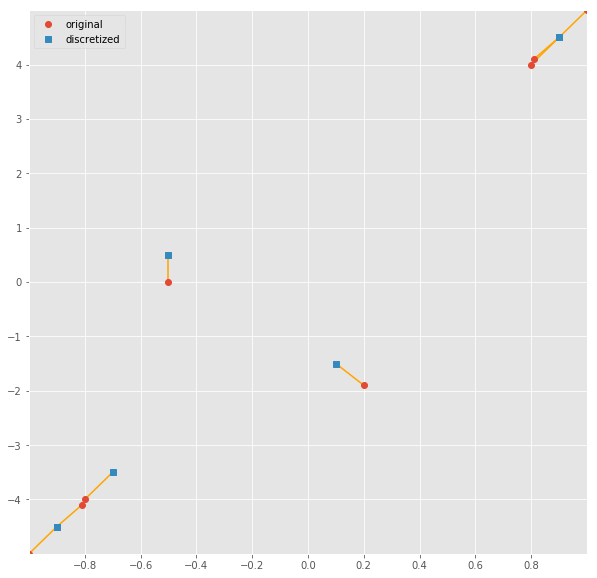

In [80]:
import matplotlib.collections as mc

def visualize_samples(samples, discretized_samples, grid, low=None, high=None):
    """Visualize original and discretized samples on a given 2-dimensional grid."""

    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Show grid
    ax.xaxis.set_major_locator(plt.FixedLocator(grid[0]))
    ax.yaxis.set_major_locator(plt.FixedLocator(grid[1]))
    ax.grid(True)
    
    # If bounds (low, high) are specified, use them to set axis limits
    if low is not None and high is not None:
        ax.set_xlim(low[0], high[0])
        ax.set_ylim(low[1], high[1])
    else:
        # Otherwise use first, last grid locations as low, high (for further mapping discretized samples)
        low = [splits[0] for splits in grid]
        high = [splits[-1] for splits in grid]

    # Map each discretized sample (which is really an index) to the center of corresponding grid cell
    grid_extended = np.hstack((np.array([low]).T, grid, np.array([high]).T))  # add low and high ends
    grid_centers = (grid_extended[:, 1:] + grid_extended[:, :-1]) / 2  # compute center of each grid cell
    locs = np.stack(grid_centers[i, discretized_samples[:, i]] for i in range(len(grid))).T  # map discretized samples

    ax.plot(samples[:, 0], samples[:, 1], 'o')  # plot original samples
    ax.plot(locs[:, 0], locs[:, 1], 's')  # plot discretized samples in mapped locations
    ax.add_collection(mc.LineCollection(list(zip(samples, locs)), colors='orange'))  # add a line connecting each original-discretized sample
    ax.legend(['original', 'discretized'])

    
visualize_samples(samples, discretized_samples, grid, low, high)

Now that we have a way to discretize a state space, let's apply it to our reinforcement learning environment.

In [81]:
# Create a grid to discretize the state space
state_grid = create_uniform_grid(env.observation_space.low, env.observation_space.high, bins=(10, 10))
state_grid

[array([-1.02, -0.84, -0.66, -0.48, -0.3 , -0.12,  0.06,  0.24,  0.42]),
 array([-0.056, -0.042, -0.028, -0.014,  0.   ,  0.014,  0.028,  0.042,  0.056])]

/Users/cheuky/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


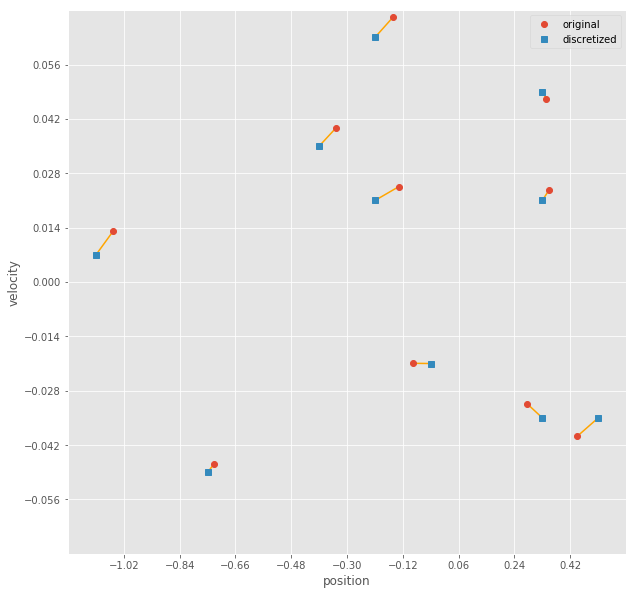

In [82]:
# Obtain some samples from the space, discretize them, and then visualize them
state_samples = np.array([env.observation_space.sample() for i in range(10)])
discretized_state_samples = np.array([discretize(sample, state_grid) for sample in state_samples])
visualize_samples(state_samples, discretized_state_samples, state_grid,
                  env.observation_space.low, env.observation_space.high)
plt.xlabel('position'); plt.ylabel('velocity');  # axis labels for MountainCar-v0 state space

You might notice that if you have enough bins, the discretization doesn't introduce too much error into your representation.  So we may be able to now apply a reinforcement learning algorithm (like Q-Learning) that operates on discrete spaces.  Give it a shot to see how well it works!

### 5. Q-Learning

Provided below is a simple Q-Learning agent. Implement the `preprocess_state()` method to convert each continuous state sample to its corresponding discretized representation.

In [ ]:
class QLearningAgent:
    """Q-Learning agent that can act on a continuous state space by discretizing it."""

    def __init__(self, env, state_grid, alpha=0.02, gamma=0.99,
                 epsilon=1.0, epsilon_decay_rate=0.9995, min_epsilon=.01, seed=505):
        """Initialize variables, create grid for discretization."""
        # Environment info
        self.env = env
        self.state_grid = state_grid
        self.state_size = tuple(len(splits) + 1 for splits in self.state_grid)  # n-dimensional state space
        self.action_size = self.env.action_space.n  # 1-dimensional discrete action space
        self.seed = np.random.seed(seed)
        print("Environment:", self.env)
        print("State space size:", self.state_size)
        print("Action space size:", self.action_size)
        
        # Learning parameters
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount factor
        self.epsilon = self.initial_epsilon = epsilon  # initial exploration rate
        self.epsilon_decay_rate = epsilon_decay_rate # how quickly should we decrease epsilon
        self.min_epsilon = min_epsilon
        
        # Create Q-table
        self.q_table = np.zeros(shape=(self.state_size + (self.action_size,)))
        print("Q table size:", self.q_table.shape)

    def preprocess_state(self, state):
        """Map a continuous state to its discretized representation."""
        # TODO: Implement this
        pass

    def reset_episode(self, state):
        """Reset variables for a new episode."""
        # Gradually decrease exploration rate
        self.epsilon *= self.epsilon_decay_rate
        self.epsilon = max(self.epsilon, self.min_epsilon)

        # Decide initial action
        self.last_state = self.preprocess_state(state)
        self.last_action = np.argmax(self.q_table[self.last_state])
        return self.last_action
    
    def reset_exploration(self, epsilon=None):
        """Reset exploration rate used when training."""
        self.epsilon = epsilon if epsilon is not None else self.initial_epsilon

    def act(self, state, reward=None, done=None, mode='train'):
        """Pick next action and update internal Q table (when mode != 'test')."""
        state = self.preprocess_state(state)
        if mode == 'test':
            # Test mode: Simply produce an action
            action = np.argmax(self.q_table[state])
        else:
            # Train mode (default): Update Q table, pick next action
            # Note: We update the Q table entry for the *last* (state, action) pair with current state, reward
            self.q_table[self.last_state + (self.last_action,)] += self.alpha * \
                (reward + self.gamma * max(self.q_table[state]) - self.q_table[self.last_state + (self.last_action,)])

            # Exploration vs. exploitation
            do_exploration = np.random.uniform(0, 1) < self.epsilon
            if do_exploration:
                # Pick a random action
                action = np.random.randint(0, self.action_size)
            else:
                # Pick the best action from Q table
                action = np.argmax(self.q_table[state])

        # Roll over current state, action for next step
        self.last_state = state
        self.last_action = action
        return action

    
q_agent = QLearningAgent(env, state_grid)

Let's also define a convenience function to run an agent on a given environment.  When calling this function, you can pass in `mode='test'` to tell the agent not to learn.

In [ ]:
def run(agent, env, num_episodes=20000, mode='train'):
    """Run agent in given reinforcement learning environment and return scores."""
    scores = []
    max_avg_score = -np.inf
    for i_episode in range(1, num_episodes+1):
        # Initialize episode
        state = env.reset()
        action = agent.reset_episode(state)
        total_reward = 0
        done = False

        # Roll out steps until done
        while not done:
            state, reward, done, info = env.step(action)
            total_reward += reward
            action = agent.act(state, reward, done, mode)

        # Save final score
        scores.append(total_reward)
        
        # Print episode stats
        if mode == 'train':
            if len(scores) > 100:
                avg_score = np.mean(scores[-100:])
                if avg_score > max_avg_score:
                    max_avg_score = avg_score

            if i_episode % 100 == 0:
                print("\rEpisode {}/{} | Max Average Score: {}".format(i_episode, num_episodes, max_avg_score), end="")
                sys.stdout.flush()

    return scores

scores = run(q_agent, env)

The best way to analyze if your agent was learning the task is to plot the scores. It should generally increase as the agent goes through more episodes.

In [ ]:
# Plot scores obtained per episode
plt.plot(scores); plt.title("Scores");

If the scores are noisy, it might be difficult to tell whether your agent is actually learning. To find the underlying trend, you may want to plot a rolling mean of the scores. Let's write a convenience function to plot both raw scores as well as a rolling mean.

In [ ]:
def plot_scores(scores, rolling_window=100):
    """Plot scores and optional rolling mean using specified window."""
    plt.plot(scores); plt.title("Scores");
    rolling_mean = pd.Series(scores).rolling(rolling_window).mean()
    plt.plot(rolling_mean);
    return rolling_mean

rolling_mean = plot_scores(scores)

You should observe the mean episode scores go up over time. Next, you can freeze learning and run the agent in test mode to see how well it performs.

In [ ]:
# Run in test mode and analyze scores obtained
test_scores = run(q_agent, env, num_episodes=100, mode='test')
print("[TEST] Completed {} episodes with avg. score = {}".format(len(test_scores), np.mean(test_scores)))
_ = plot_scores(test_scores, rolling_window=10)

It's also interesting to look at the final Q-table that is learned by the agent. Note that the Q-table is of size MxNxA, where (M, N) is the size of the state space, and A is the size of the action space. We are interested in the maximum Q-value for each state, and the corresponding (best) action associated with that value.

In [ ]:
def plot_q_table(q_table):
    """Visualize max Q-value for each state and corresponding action."""
    q_image = np.max(q_table, axis=2)       # max Q-value for each state
    q_actions = np.argmax(q_table, axis=2)  # best action for each state

    fig, ax = plt.subplots(figsize=(10, 10))
    cax = ax.imshow(q_image, cmap='jet');
    cbar = fig.colorbar(cax)
    for x in range(q_image.shape[0]):
        for y in range(q_image.shape[1]):
            ax.text(x, y, q_actions[x, y], color='white',
                    horizontalalignment='center', verticalalignment='center')
    ax.grid(False)
    ax.set_title("Q-table, size: {}".format(q_table.shape))
    ax.set_xlabel('position')
    ax.set_ylabel('velocity')


plot_q_table(q_agent.q_table)

### 6. Modify the Grid

Now it's your turn to play with the grid definition and see what gives you optimal results. Your agent's final performance is likely to get better if you use a finer grid, with more bins per dimension, at the cost of higher model complexity (more parameters to learn).

In [ ]:
# TODO: Create a new agent with a different state space grid
state_grid_new = create_uniform_grid(?, ?, bins=(?, ?))
q_agent_new = QLearningAgent(env, state_grid_new)
q_agent_new.scores = []  # initialize a list to store scores for this agent

In [ ]:
# Train it over a desired number of episodes and analyze scores
# Note: This cell can be run multiple times, and scores will get accumulated
q_agent_new.scores += run(q_agent_new, env, num_episodes=50000)  # accumulate scores
rolling_mean_new = plot_scores(q_agent_new.scores)

In [ ]:
# Run in test mode and analyze scores obtained
test_scores = run(q_agent_new, env, num_episodes=100, mode='test')
print("[TEST] Completed {} episodes with avg. score = {}".format(len(test_scores), np.mean(test_scores)))
_ = plot_scores(test_scores)

In [ ]:
# Visualize the learned Q-table
plot_q_table(q_agent_new.q_table)

### 7. Watch a Smart Agent

In [ ]:
state = env.reset()
score = 0
for t in range(200):
    action = q_agent_new.act(state, mode='test')
    env.render()
    state, reward, done, _ = env.step(action)
    score += reward
    if done:
        break 
print('Final score:', score)
env.close()